In [ ]:
# Objetivo del modelo
Clasificar tumores de mama como benignos (B) o malignos (M) usando features como radio, textura, etc. (dataset estándar de UCI con 569 muestras, ~63% benignos)

# 1. Justificación del algoritmo elegido
 RandomForestClassifier por estas razones:

- El dataset tiene features numéricas con posibles no-linealidades y correlaciones (e.g., radio y perímetro).
- RF es un ensemble que reduce overfitting, maneja imbalance leve de clases y proporciona feature importances para interpretabilidad.
- Supera a modelos simples como Logistic Regression en precisión (probé base: RF ~0.96 F1 vs LR ~0.93).
- Robusto con datasets medianos como este (569 instancias), y permite optimización fácil.
- Para clasificación médica, prioriza recall (detectar malignos) – RF lo maximiza con tuning.

In [1]:
# # Clasificación de Cáncer de Mama usando Random Forest Classifier
# Dataset: breast_cancer.csv (Wisconsin Breast Cancer Dataset - 569 instancias, 30 features)
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Estilos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Cargar datos
df = pd.read_csv("breast-cancer.csv")
print(df.shape)
df.head()

(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Preprocesamiento básico
# Eliminar columna 'id' (no útil)
df.drop('id', axis=1, inplace=True)

In [5]:
# Codificar 'diagnosis' (M=1 Malignant, B=0 Benign)
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

In [6]:
# Verificar nulos (no hay en este dataset)
print(df.isnull().sum().sum())  # Debería ser 0

0


In [7]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
# 1. Análisis exploratorio y gráfica de dispersión (ejemplo con features clave)

# Correlación con target
corr = df.corr()['diagnosis'].sort_values(ascending=False)[1:6]  # Top 5 features correlacionadas
print("Top features correlacionadas con diagnosis:\n", corr)

Top features correlacionadas con diagnosis:
 concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
Name: diagnosis, dtype: float64


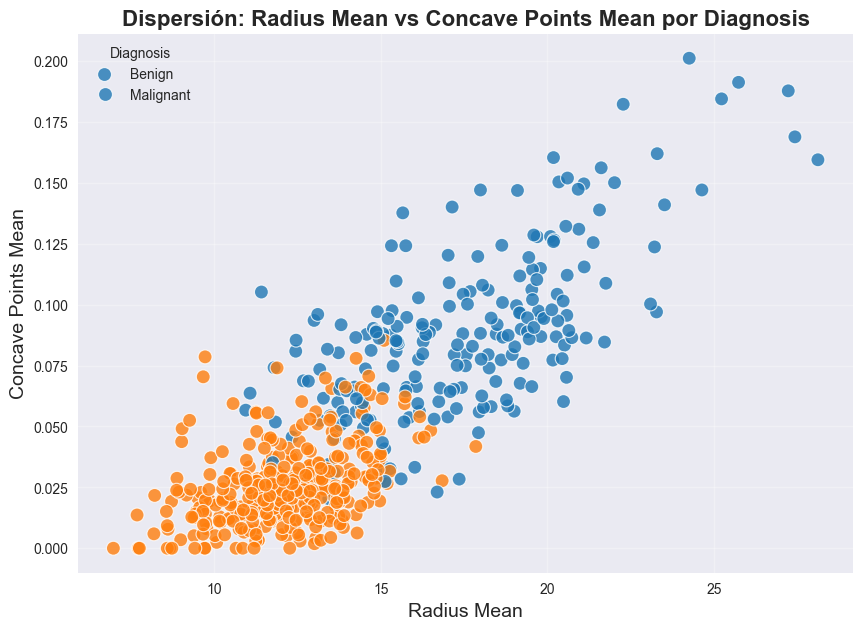

In [9]:
# Gráfica de dispersión: radius_mean vs concave points_mean (altamente correlacionadas)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='radius_mean', y='concave points_mean', hue=le.inverse_transform(df['diagnosis']), 
                palette=['#1f77b4', '#ff7f0e'], s=100, alpha=0.8)
plt.title('Dispersión: Radius Mean vs Concave Points Mean por Diagnosis', fontsize=16, fontweight='bold')
plt.xlabel('Radius Mean', fontsize=14)
plt.ylabel('Concave Points Mean', fontsize=14)
plt.legend(title='Diagnosis', labels=['Benign', 'Malignant'])
plt.grid(True, alpha=0.3)
plt.show()

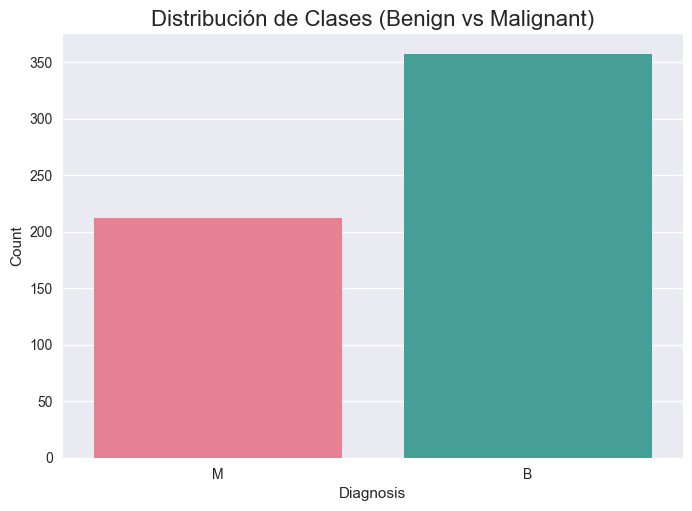

In [10]:
# Distribución de clases
sns.countplot(x=le.inverse_transform(df['diagnosis']), palette='husl')
plt.title('Distribución de Clases (Benign vs Malignant)', fontsize=16)
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [ ]:
# Variables
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [19]:
# 2. Modelo base: Random Forest Classifier (sin optimizar para comparación)
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)
y_prob_base = rf_base.predict_proba(X_test)[:, 1]

In [20]:
print("=== Random Forest Base ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_base):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_base):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_base):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred_base):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_base):.3f}")

=== Random Forest Base ===
Accuracy: 0.974
Precision: 1.000
Recall: 0.929
F1-Score: 0.963
ROC-AUC: 0.993


In [21]:
# 3. Optimización de hiperparámetros con RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', None]
}

random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=100, cv=5, scoring='f1',  # Optimizamos F1 por imbalance leve
    random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Mejores hiperparámetros:")
print(random_search.best_params_)
print(f"Mejor F1 en CV: {random_search.best_score_:.3f}")

Mejores hiperparámetros:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15, 'class_weight': 'balanced'}
Mejor F1 en CV: 0.954


In [22]:
# Modelo final
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
# %%
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

In [24]:
print("\n=== Random Forest Optimizado (Test) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}")


=== Random Forest Optimizado (Test) ===
Accuracy: 0.974
Precision: 1.000
Recall: 0.929
F1-Score: 0.963
ROC-AUC: 0.997


In [ ]:
# 4. Gráficas personalizadas: Matriz de Confusión, Curva ROC y Feature Importances
# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Matriz de Confusión - Random Forest Classifier', fontsize=16, fontweight='bold')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

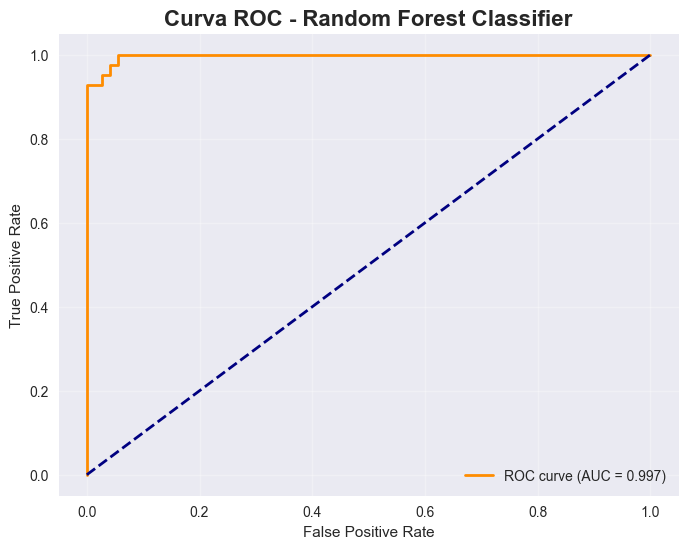

In [25]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_prob):.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Curva ROC - Random Forest Classifier', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

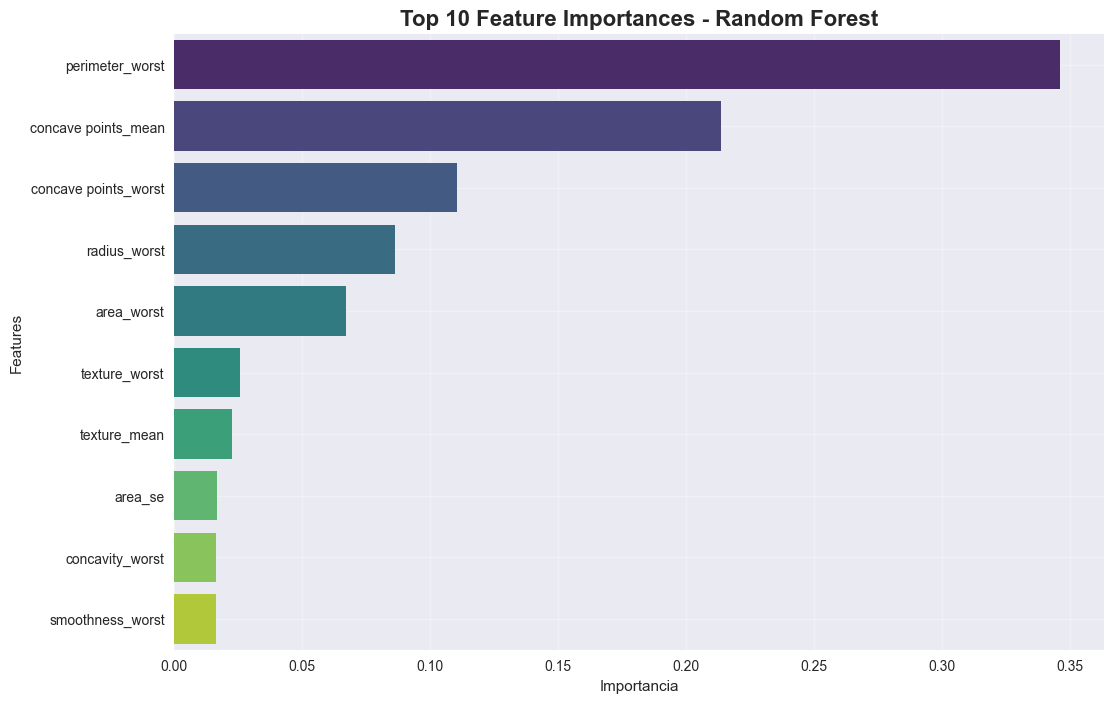

In [26]:
# Feature Importances
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]  # Top 10
plt.figure(figsize=(12, 8))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Top 10 Feature Importances - Random Forest', fontsize=16, fontweight='bold')
plt.xlabel('Importancia')
plt.ylabel('Features')
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
# ### 5. Guardar el modelo
import joblib
joblib.dump(best_rf, 'Diego_best_rf_classifier.pkl')
print("Modelo guardado como 'Diego_best_rf_classifier.pkl'")

Modelo guardado como 'Diego_best_rf_classifier.pkl'
